In [19]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
from pathlib import Path
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
from scipy.linalg import cholesky, lstsq


In [21]:
from experiments import EffectCorrelation
from experiments import utilities as utils
from bayesinverse import Regression
import robiplotipy.experiments.effect_correlation as plt_exp
from robiplotipy import PlotEnv


In [22]:

config_path = config_path = Path(
    "/home/rmaiwald/code/Experiments/experiments/effect_correlation/config.yaml"
)

exp = EffectCorrelation(config_path)


sensors 0.0035765916109085083
emissions 1.5357737392187119
transport 4.259907841682434


In [23]:
exp.load_data()
rmse_list = exp.data["rmse_list"]
posterior_list = exp.data["posterior_list"]
posterior_covariance_list = exp.data["posterior_covariance_list"]
corr_strength_list = exp.data["corr_strength_list"]

Plotting

Plot effect of correlation length for each sector

In [24]:
point_index = exp.emissions.source_group_df.query("source_type == 'point source'").index
traffic_index = exp.emissions.source_group_df.query("source_type == 'line source'").index
tno_area_index = exp.emissions.source_group_df.query("source_type == 'TNO area'").index
heating_index = exp.emissions.source_group_df.query("source_type == 'Stadtwerke area'").index
valid_index = exp.emissions.source_group_df.query("source_type != '0.0'").index

In [25]:
plot_env = PlotEnv(
    fig_path="/home/rmaiwald/results/plotting/effect_correlation/",
    logging=True,
    display=True,
)

In [26]:
index_list = [point_index, traffic_index, tno_area_index, heating_index, valid_index]
label_list = ["points", "traffic", "TNO area", "Stadtwerke", "Total"]
data_list = []
for index, label in zip(index_list, label_list):
    rmse_list = []
    for posterior in posterior_list:
        error =  posterior - exp.emissions.truth_absolute
        rmse_list.append(np.sqrt(np.mean(error.sel(source_group=index).sum("source_group")**2)))
    data_list.append(rmse_list)
y_label = r"RMSE of the sum of the CO$_2$ emissions [kg/h]"

[Errno 17] File exists: '/home/rmaiwald/results/plotting/effect_correlation/absolute_rmse_over_correlation/config_log.yml'


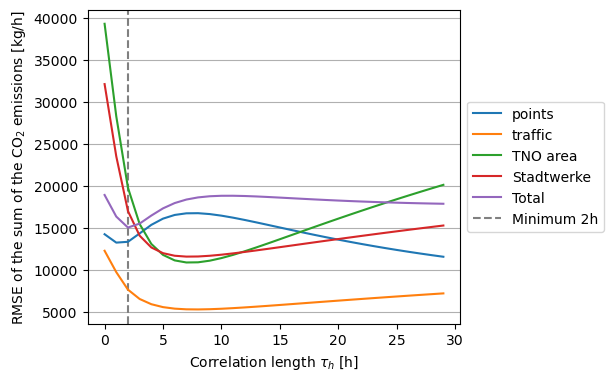

In [27]:
with plot_env(
    name="absolute_rmse_over_correlation",
    notes=exp.config,
):
    plt_exp.plot_list_over_correlation_length(
        env=plot_env,
        correlation_list=corr_strength_list,
        data_list=data_list,
        data_label_list=label_list,
        y_label=y_label,
    )


In [28]:
# index_list = [point_index, traffic_index, heating_index, valid_index]
# label_list = ["points", "traffic", "Stadtwerke", "Total"]
index_list = [point_index, traffic_index, tno_area_index, heating_index, valid_index]
label_list = ["points", "traffic", "TNO area", "Stadtwerke", "Total"]
data_list = []
for index, label in zip(index_list, label_list):
    rmse_list = []
    for posterior in posterior_list:
        error = posterior - exp.emissions.truth_absolute
        scaling = np.sqrt((
            (posterior_list[0] - exp.emissions.truth_absolute).sel(source_group=index)
            .sum("source_group")**2)
            .mean()
        )
        # scaling = np.sqrt((
        #     exp.emissions.truth_absolute.sel(source_group=index)
        #     .sum("source_group")**2)
        #     .mean()
        # )
        rmse = np.sqrt(np.mean(error.sel(source_group=index).sum("source_group") ** 2))
        rmse_list.append(rmse / scaling * 100)
    data_list.append(rmse_list)

y_label = r"Relative RMSE of the sum of the CO$_2$ emissions [%]"

[Errno 17] File exists: '/home/rmaiwald/results/plotting/effect_correlation/relative_rmse_over_correlation/config_log.yml'


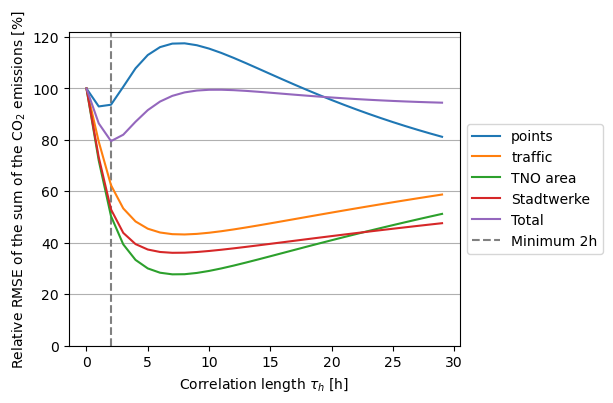

In [29]:
with plot_env(
    name="relative_rmse_over_correlation",
    notes=exp.config,
):
    plt_exp.plot_list_over_correlation_length(
        env=plot_env,
        correlation_list=corr_strength_list,
        data_list=data_list,
        data_label_list=label_list,
        y_label=y_label,
        bottom=0,
    )


In [30]:
total_rmse = np.array(data_list)[np.where(np.array(label_list) == "Total")]
min_id = total_rmse.argmin()
minimum = corr_strength_list[min_id]
minimum

2.00000001

Without point sources

In [31]:
mask = (
    (exp.emissions.source_group_df["source_type"] == "line source")
    | (exp.emissions.source_group_df["source_type"] == "TNO area")
    | (exp.emissions.source_group_df["source_type"] == "Stadtwerke area")
)
source_groups_without_points = exp.emissions.source_group_df.index[mask]

In [32]:
time, mean, std, mean_cor, std_cor, mean_prior, mean_truth = utils.get_plotting_params(
    exp=exp,
    posterior_0=posterior_list[0],
    posterior_covariance_0=posterior_covariance_list[0],
    posterior_1=posterior_list[min_id],
    posterior_covariance_1=posterior_covariance_list[min_id],
    index=source_groups_without_points,
)
y_label = r"Total CO$_2$ emissions without point sources [kg/h]"

[Errno 17] File exists: '/home/rmaiwald/results/plotting/effect_correlation/correlation_without_point_sources/config_log.yml'


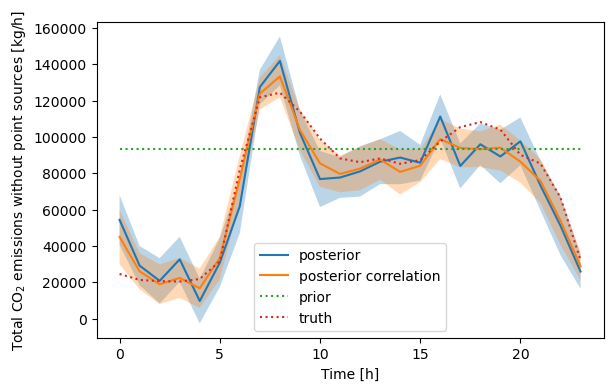

In [33]:
with plot_env(
    name="correlation_without_point_sources",
    notes=exp.config,
    ):
    plt_exp.plot_correlation_time_series(
        env=plot_env,
        time=time,
        mean=mean,
        std=std,
        mean_cor=mean_cor,
        std_cor=std_cor,
        mean_prior=mean_prior,
        mean_truth=mean_truth,
        y_label=y_label
    )

With point sources

In [34]:
time, mean, std, mean_cor, std_cor, mean_prior, mean_truth = utils.get_plotting_params(
    exp=exp,
    posterior_0=posterior_list[0],
    posterior_covariance_0=posterior_covariance_list[0],
    posterior_1=posterior_list[min_id],
    posterior_covariance_1=posterior_covariance_list[min_id],
    index=valid_index,
)
y_label= r"Total CO$_2$ emissions [kg/h]"

[Errno 17] File exists: '/home/rmaiwald/results/plotting/effect_correlation/correlation/config_log.yml'


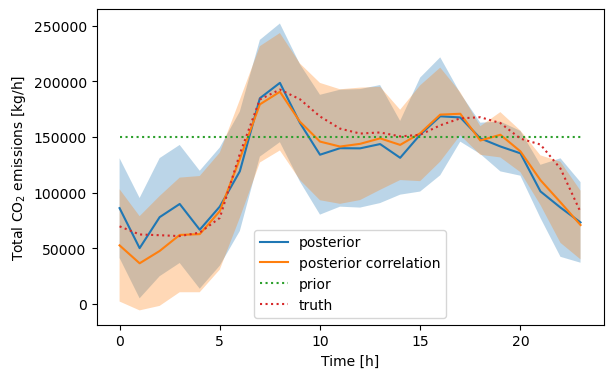

In [35]:
with plot_env(
    name="correlation",
    notes=exp.config,
    ):
    plt_exp.plot_correlation_time_series(
        env=plot_env,
        time=time,
        mean=mean,
        std=std,
        mean_cor=mean_cor,
        std_cor=std_cor,
        mean_prior=mean_prior,
        mean_truth=mean_truth,
        y_label=y_label,
    )

Just points

In [36]:
time, mean, std, mean_cor, std_cor, mean_prior, mean_truth = utils.get_plotting_params(
    exp=exp,
    posterior_0=posterior_list[0],
    posterior_covariance_0=posterior_covariance_list[0],
    posterior_1=posterior_list[min_id],
    posterior_covariance_1=posterior_covariance_list[min_id],
    index=point_index,
)
y_label = r"Total CO$_2$ emissions from point sources [kg/h]"

[Errno 17] File exists: '/home/rmaiwald/results/plotting/effect_correlation/correlation_points/config_log.yml'


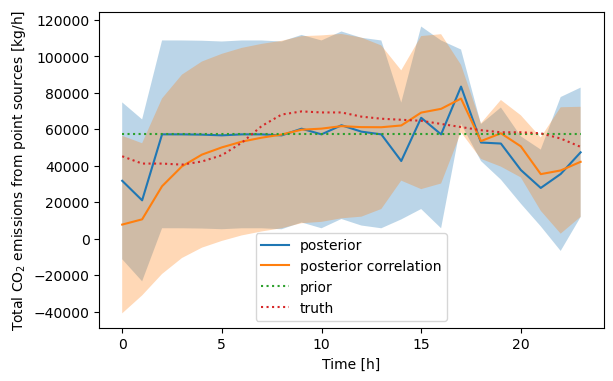

In [37]:
with plot_env(
    name="correlation_points",
    notes=exp.config,
    ):
    plt_exp.plot_correlation_time_series(
        env=plot_env,
        time=time,
        mean=mean,
        std=std,
        mean_cor=mean_cor,
        std_cor=std_cor,
        mean_prior=mean_prior,
        mean_truth=mean_truth,
        y_label=y_label,
    )

Traffic

In [38]:
time, mean, std, mean_cor, std_cor, mean_prior, mean_truth = utils.get_plotting_params(
    exp=exp,
    posterior_0=posterior_list[0],
    posterior_covariance_0=posterior_covariance_list[0],
    posterior_1=posterior_list[min_id],
    posterior_covariance_1=posterior_covariance_list[min_id],
    index=traffic_index,
)
y_label = r"Total CO$_2$ emissions from traffic sources [kg/h]"

[Errno 17] File exists: '/home/rmaiwald/results/plotting/effect_correlation/correlation_traffic/config_log.yml'


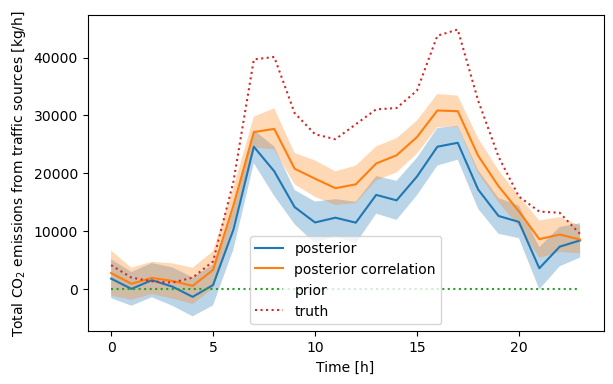

In [39]:
with plot_env(
    name="correlation_traffic",
    notes=exp.config,
    ):
    plt_exp.plot_correlation_time_series(
        env=plot_env,
        time=time,
        mean=mean,
        std=std,
        mean_cor=mean_cor,
        std_cor=std_cor,
        mean_prior=mean_prior,
        mean_truth=mean_truth,
        y_label=y_label,
    )

TNO area

In [40]:
time, mean, std, mean_cor, std_cor, mean_prior, mean_truth = utils.get_plotting_params(
    exp=exp,
    posterior_0=posterior_list[0],
    posterior_covariance_0=posterior_covariance_list[0],
    posterior_1=posterior_list[min_id],
    posterior_covariance_1=posterior_covariance_list[min_id],
    index=tno_area_index,
)
y_label = r"Total CO$_2$ emissions from TNO area sources [kg/h]"

[Errno 17] File exists: '/home/rmaiwald/results/plotting/effect_correlation/correlation_TNO_area/config_log.yml'


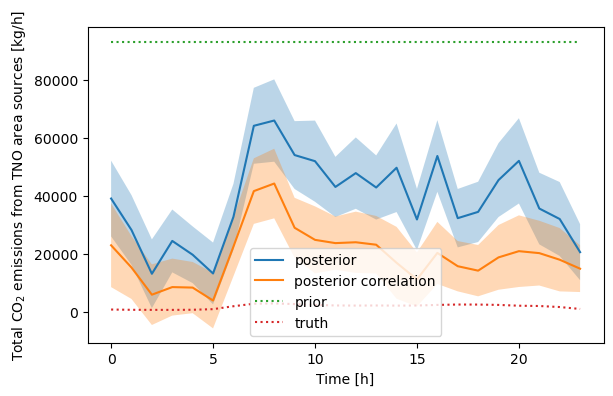

In [41]:
with plot_env(
    name="correlation_TNO_area",
    notes=exp.config,
    ):
    plt_exp.plot_correlation_time_series(
        env=plot_env,
        time=time,
        mean=mean,
        std=std,
        mean_cor=mean_cor,
        std_cor=std_cor,
        mean_prior=mean_prior,
        mean_truth=mean_truth,
        y_label=y_label,
    )

Stationary combustion

In [42]:
time, mean, std, mean_cor, std_cor, mean_prior, mean_truth = utils.get_plotting_params(
    exp=exp,
    posterior_0=posterior_list[0],
    posterior_covariance_0=posterior_covariance_list[0],
    posterior_1=posterior_list[min_id],
    posterior_covariance_1=posterior_covariance_list[min_id],
    index=heating_index,
)
y_label = r"Total CO$_2$ emissions from stationary combustion area sources [kg/h]"

[Errno 17] File exists: '/home/rmaiwald/results/plotting/effect_correlation/correlation_heating/config_log.yml'


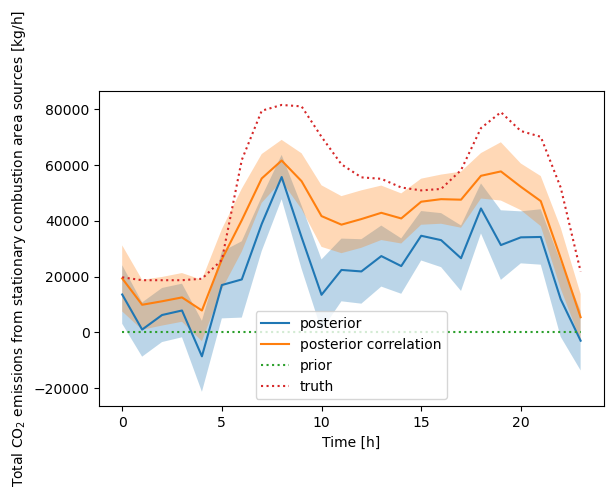

In [43]:
with plot_env(
    name="correlation_heating",
    notes=exp.config,
    ):
    plt_exp.plot_correlation_time_series(
        env=plot_env,
        time=time,
        mean=mean,
        std=std,
        mean_cor=mean_cor,
        std_cor=std_cor,
        mean_prior=mean_prior,
        mean_truth=mean_truth,
        y_label=y_label,
    )

Overview

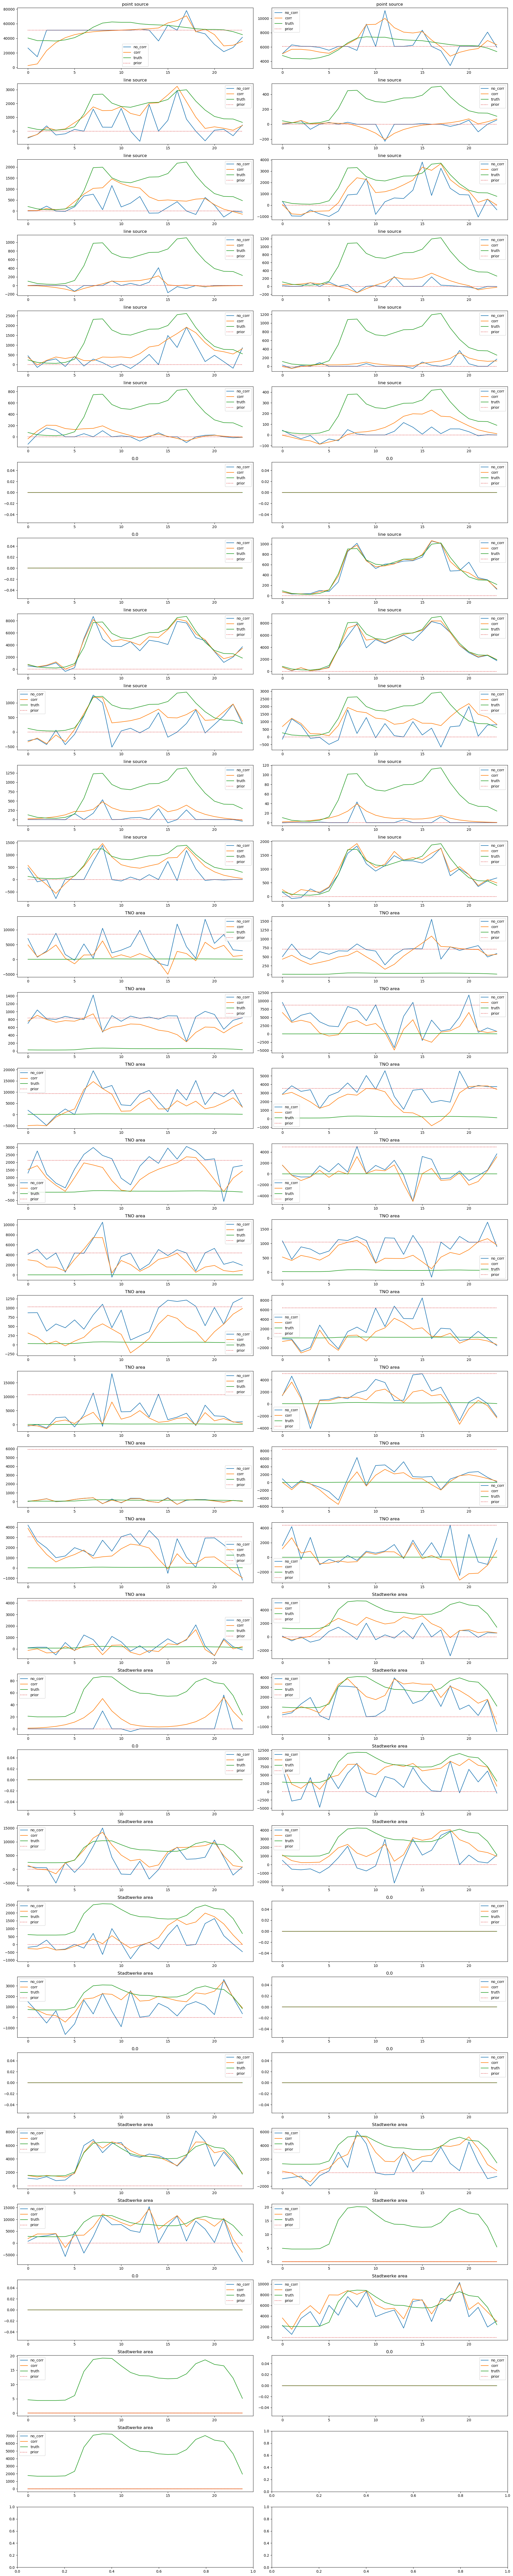

In [44]:
fig, axs = plt.subplots(figsize=(20, 100), nrows=34, ncols=2)
fig.set_dpi(100)

axs = axs.flatten()

for i, source_group in enumerate(
    exp.emissions.prior["source_group"].values
):
    prior_sum = exp.emissions.prior["source_group"].sel(source_group=source_group).sum()
    truth_sum = exp.emissions.truth["source_group"].sel(source_group=source_group).sum()
    if prior_sum > 0 or truth_sum > 0:
        ax = axs[i]
        ax.plot(
            (utils.unstack_xr(posterior_list[0])).sel(source_group=source_group),
            "-",
            label="no_corr",
        )
        ax.plot(
            (utils.unstack_xr(posterior_list[min_id])).sel(source_group=source_group),
            "-",
            label="corr",
        )
        ax.plot(exp.emissions.truth_absolute.sel(source_group=source_group), label="truth")
        ax.plot(
            exp.emissions.prior_absolute.sel(source_group=source_group), ":", label="prior"
        )
        ax.set_title(exp.emissions.source_group_df["source_type"].loc[source_group])
        ax.legend()
    else:
        i -= 1
plt.tight_layout()